In [51]:
from glob import glob
from PIL import Image
import yaml
import cv2
from src.models import ConvNextClassifier, get_transforms 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [52]:
def load_config(config_file='config.yaml'):
    with open(config_file, 'r') as file :
        config=yaml.safe_load(file)
    return config

config=load_config('config.yaml')

In [53]:
class_names = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']

In [57]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

model=ConvNextClassifier(num_classes=config['num-classes'], 
                    model_size='base',
                    pretrained=True,
                    freeze_backborn=True,
                    ).to(device)
checkpoint = torch.load("model_save/best_model.pt", map_location=device)
model.load_state_dict(checkpoint["model"])
model.eval()

softmax = nn.Softmax()

/tmp/ipykernel_184040/1933180101.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model_save/best_model.pt", map_location=device)


##### Test images downloaded from the Internet

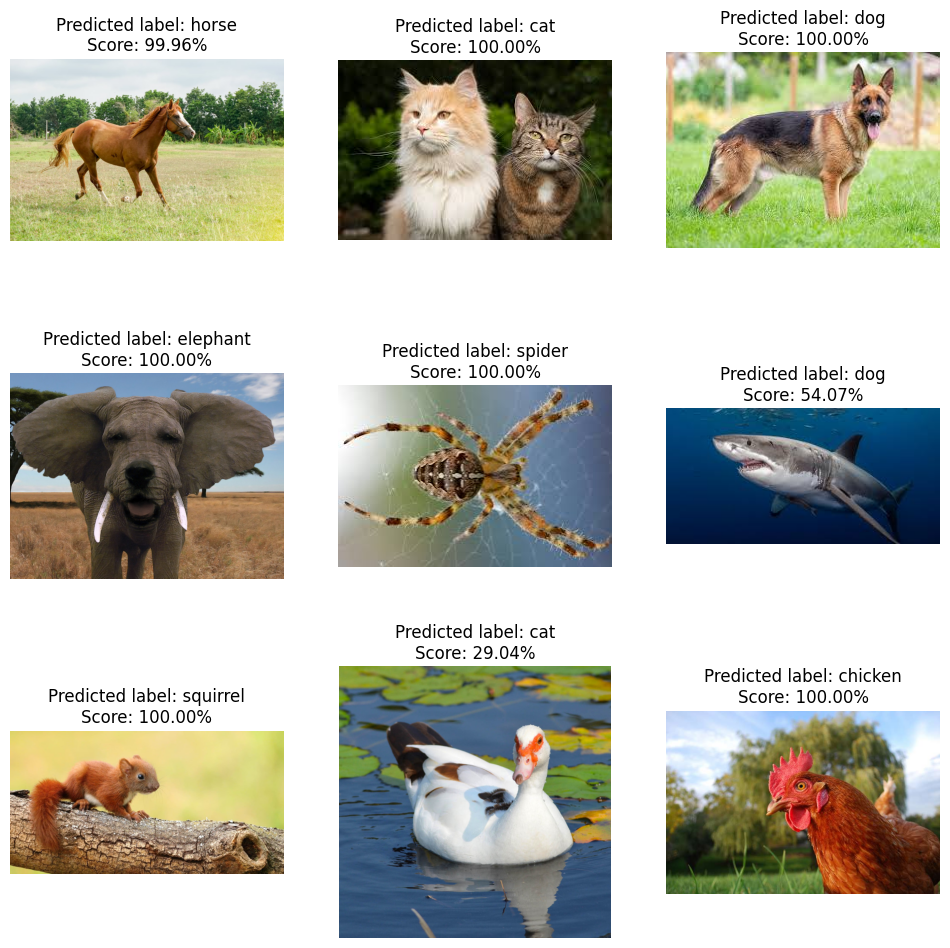

In [60]:
test_paths=glob("test_image/*")

fig, ax=plt.subplots(3,3, figsize=(12,12))

for index, value in enumerate(test_paths):
    r = index // 3
    c = index % 3   
    ax_i = ax[r, c]
    
    img_bgr = cv2.imread(value)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    pil_img=Image.fromarray(img_rgb)
    
    transform = get_transforms(img_size=224, is_training=False)
    img_tensor=transform(pil_img).to(device).unsqueeze(0) #Add batch dimension
    with torch.no_grad():
        output = model(img_tensor)
        probs=softmax(output)
        pred_idx = output.argmax(dim=1).item()
        pred_label = class_names[pred_idx]   
    
    ax_i.imshow(img_rgb)
    ax_i.set_title(f"Predicted label: {pred_label}\nScore: {probs[0, pred_idx]*100:.2f}%")
    ax_i.axis("off")  
